# CLASSIFICATION INTO NORMAL/HERNIA/SPONDILOLYTHESIS

We have a data set containing values for six biomechanical features used to classify orthopaedic patients into 3 classes (normal, disk hernia or spondilolysthesis)

source - https://www.kaggle.com/caesarlupum/vertebralcolumndataset

The data have been organized in two different but related classification tasks. The first task consists in classifying patients as belonging to one out of three categories: Normal (100 patients), Disk Hernia (60 patients) or Spondylolisthesis (150 patients).

Objective= Classifying the categories of patient by using deep learning

Implication= Medical research 

In [1]:
## Import the required libraries 
library(tensorflow)
library(keras)
library(rlang)
library(tfdatasets)
library(caTools)
library(dplyr)
library(reticulate)
library(GGally)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
## Import the data 
data= read.csv('/home/kriti/Downloads/column_3C.csv',header=T)
tail(data)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
305,45.07545,12.306951,44.58318,32.76850,147.8946,-8.941709,Normal
306,47.90357,13.616688,36.00000,34.28688,117.4491,-4.245395,Normal
307,53.93675,20.721496,29.22053,33.21525,114.3658,-0.421010,Normal
308,61.44660,22.694968,46.17035,38.75163,125.6707,-2.707880,Normal
309,45.25279,8.693157,41.58313,36.55964,118.5458,0.214750,Normal
310,33.84164,5.073991,36.64123,28.76765,123.9452,-0.199249,Normal


In [3]:
dim(data)

[1] 310   7

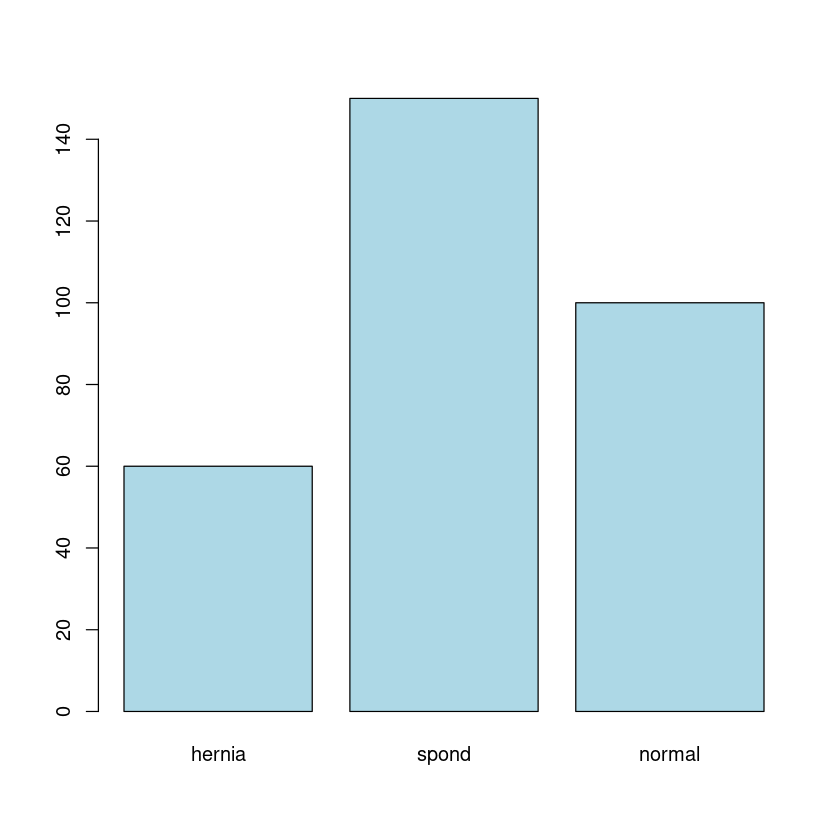

In [4]:
##Some basic analysis to understand the data.
hernia=length(which(data$class %in% "Hernia"))
normal=length(which(data$class %in% "Normal"))
spond=length(which(data$class %in% "Spondylolisthesis"))
barplot(cbind(hernia,spond,normal),col="lightblue")

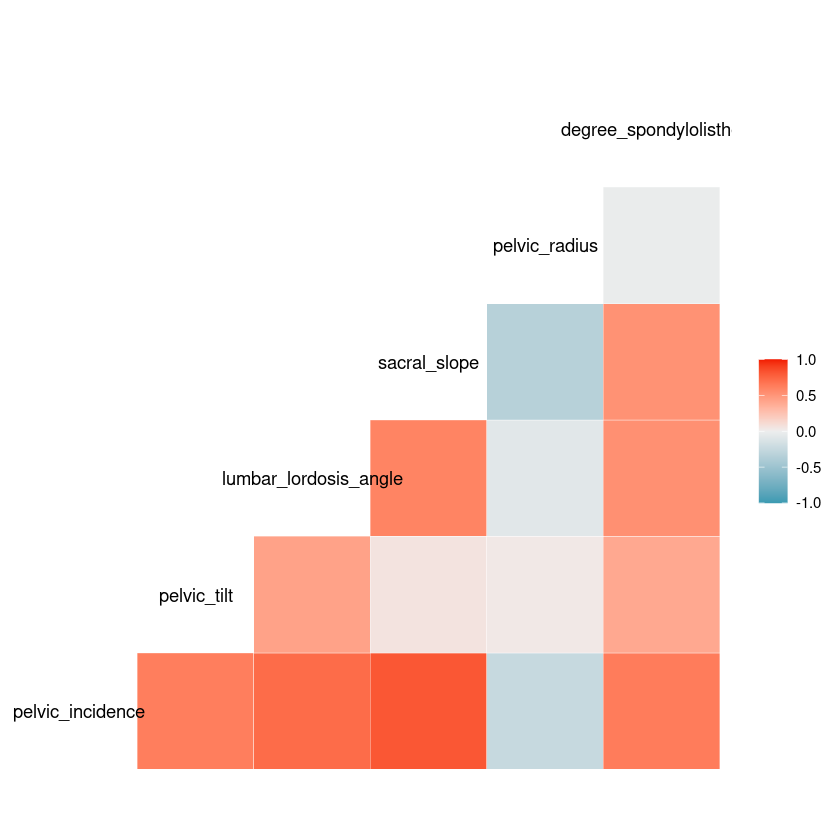

In [5]:
## PLot the correlation matrix of variables 
library(GGally)
ggcorr(data[,1:6], method = c("everything", "pearson")) 

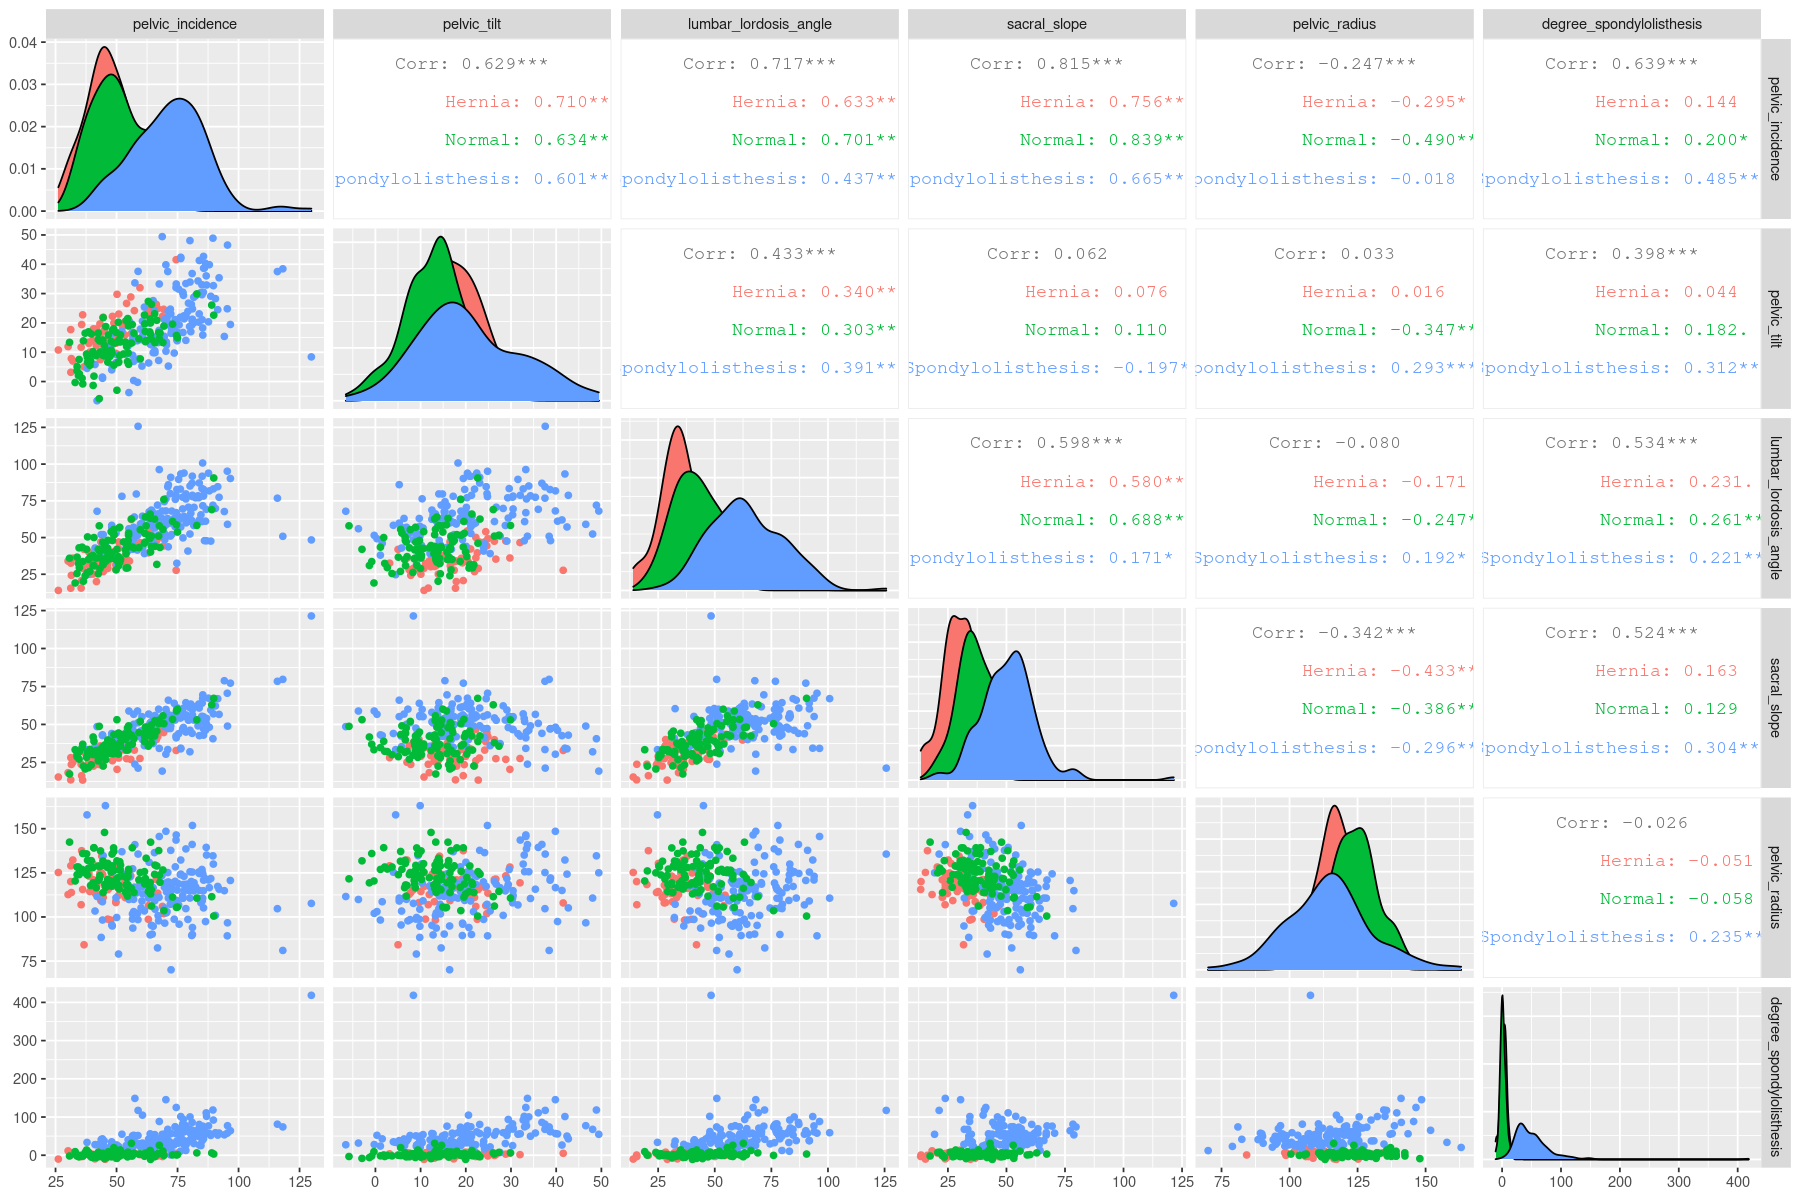

In [6]:
## then we do scatter plot to check is the data have some outliers or not.
options(repr.plot.width=15, repr.plot.height=10)
ggpairs(data, columns = 1:6, ggplot2::aes(colour=class)) 

In [7]:
###Factor the class of patients 
data$class=as.numeric(factor(data$class))
head(data)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,63.02782,22.552586,39.60912,40.47523,98.67292,-0.254400,1
2,39.05695,10.060991,25.01538,28.99596,114.40542,4.564259,1
3,68.83202,22.218482,50.09219,46.61354,105.98513,-3.530317,1
4,69.29701,24.652878,44.31124,44.64413,101.86849,11.211523,1
5,49.71286,9.652075,28.31741,40.06078,108.16872,7.918501,1
6,40.25020,13.921907,25.12495,26.32829,130.32787,2.230652,1


In [8]:
##Removing outliers from the code.
index=NULL
for(i in 1:6){
outliers <- boxplot(data[,i], plot=FALSE)$out
a=which(data[,i] %in% outliers)
index=c(index,a)
}
index=unique(index)
data_new=data[-index,]

In [9]:
dim(data_new)

[1] 280   7

In [10]:
##Spliting the data into test and train
set.seed(123)
split = sample.split(data_new[,1:6], SplitRatio = 0.9)
train_data = subset(data_new, split == TRUE)
test_data = subset(data_new, split == FALSE)


In [11]:
###Creating the function for modeling the data
acc=NULL
my_model<- function(train_data,test_data)  {
    column_names <- colnames(data)[-7] #add column names for better data inspection.

train_df <- train_data[,1:6] %>% 
  as_tibble(.name_repair = "minimal") %>% 
  setNames(column_names) %>% 
  mutate(label = train_data$class)

test_df <- test_data[,1:6] %>% 
  as_tibble(.name_repair = "minimal") %>% 
  setNames(column_names) %>% 
  mutate(label = test_data$class)

##Normalize the data 
  spec <- feature_spec(train_df, label ~ . ) %>% 
  step_numeric_column(all_numeric(), normalizer_fn = scaler_standard()) %>% 
  fit()

spec
## Now perform pre processing process directly in tensorflow graph
layer <- layer_dense_features(
  feature_columns = dense_features(spec), 
  dtype = tf$float32
)
 ## Defing the layers for the model and activation function
  build_model <- function() {
  input <- layer_input_from_dataset(train_df %>% select(-label))
  
  output <- input %>% 
    layer_dense_features(dense_features(spec)) %>% 
    layer_dense(units = 280, activation = "tanh")%>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 280, activation = "tanh")%>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 140, activation = "tanh") %>%
    layer_dense(units = 70, activation = "tanh") %>%
    layer_dense(units = 35, activation = "relu") %>%
    layer_dense(units = 1) 
  
  model <- keras_model(input, output)
  
  model %>% 
    compile(
      loss = "mse",
      optimizer = "adam",
      metrics = list("mean_absolute_error")
    )
  
  model
}
    ## now trained the model on 500 epochs

print_dot_callback <- callback_lambda(
  on_epoch_end = function(epoch, logs) {
    if (epoch %% 80 == 0) cat("\n")
    cat(".")
  }
)    

model <- build_model()

history <- model %>% fit(   ##recording the training and validation result in history object
  x = train_df %>% select(-label),
  y = train_df$label,
  epochs = 100,
  validation_split = 0.2,
  verbose = 0,
  callbacks = list(print_dot_callback)
)

pl=plot(history)
print(pl)    ##Plot the traing and validation on model
    
c(loss, mae) %<-% (model %>% evaluate(test_df %>% select(-label), test_df$label, verbose = 0))

paste0("Mean absolute error on test set: ", sprintf("%.2f", mae ))

## finally predict class on basis of training set

test_predictions <- model %>% predict(test_df %>% select(-label))

pred=round(test_predictions)
tb=table(pred,test_df$label)
acc=sum(diag(tb))/sum(tb)##Accuracy of the model on each fold
print(acc)
return(acc) 
}



................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



[1] 0.8928571

................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



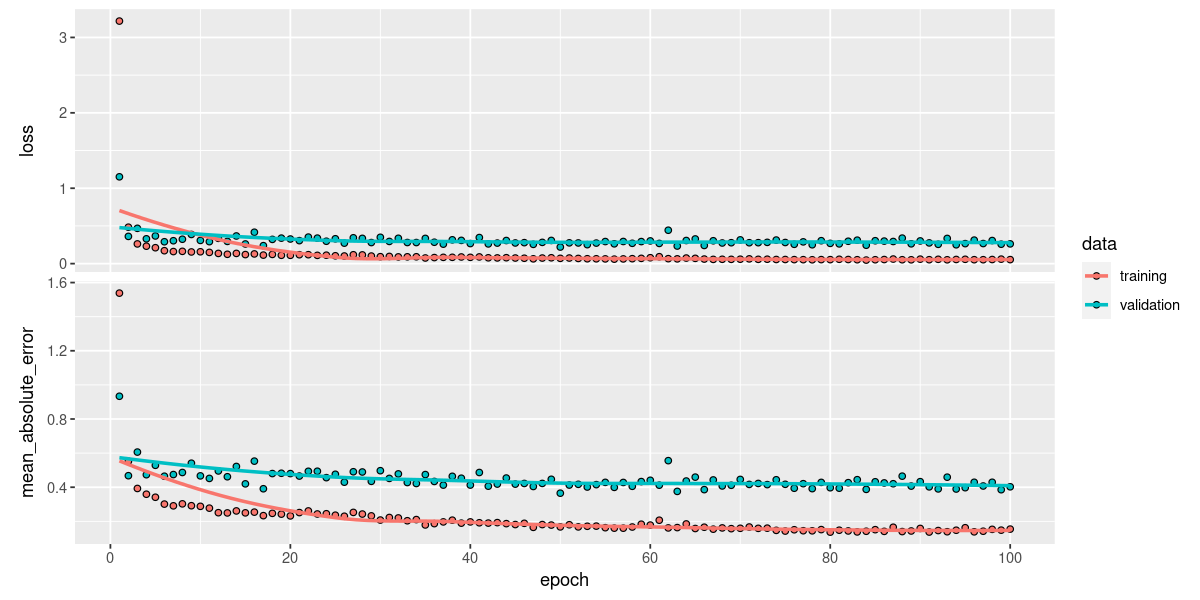

[1] 0.8571429

................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



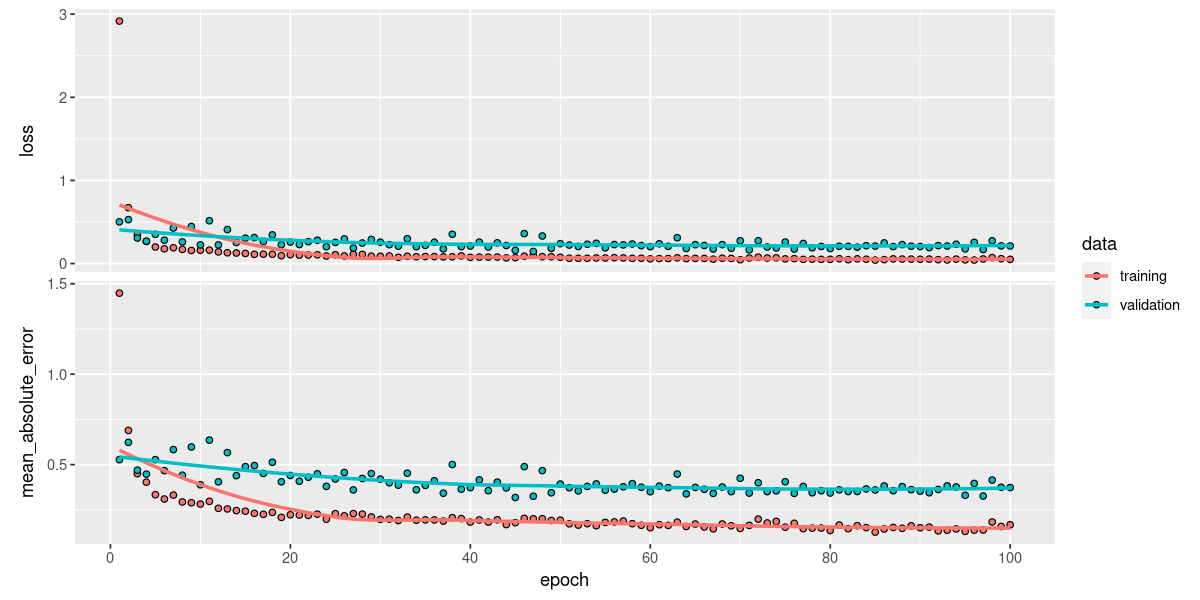

[1] 0.8928571

................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



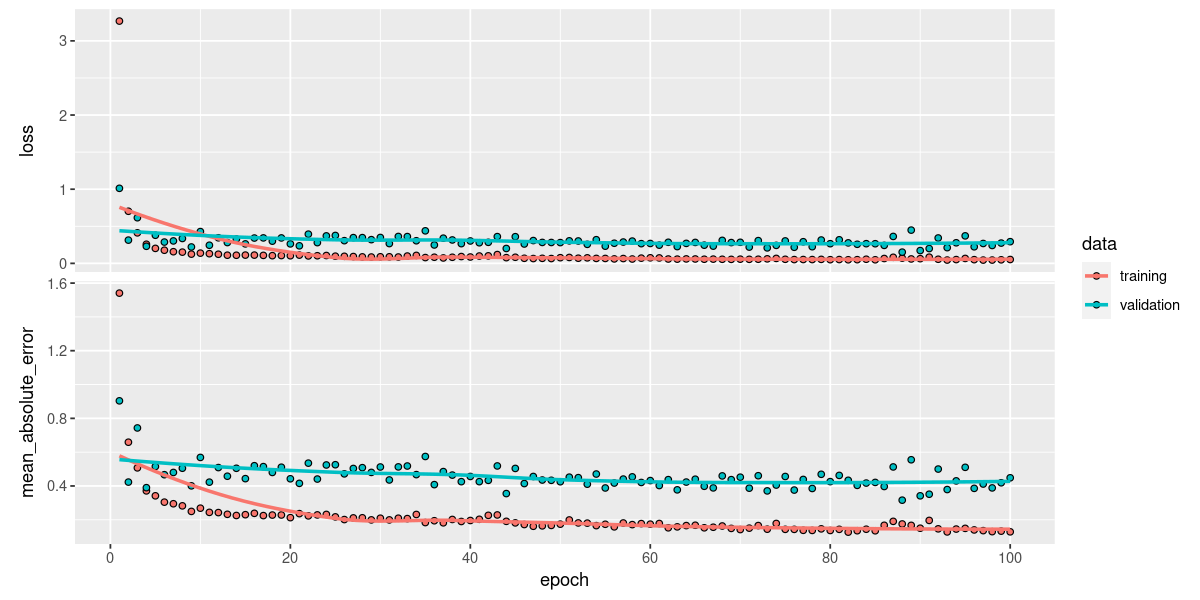

[1] 0.8928571

................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



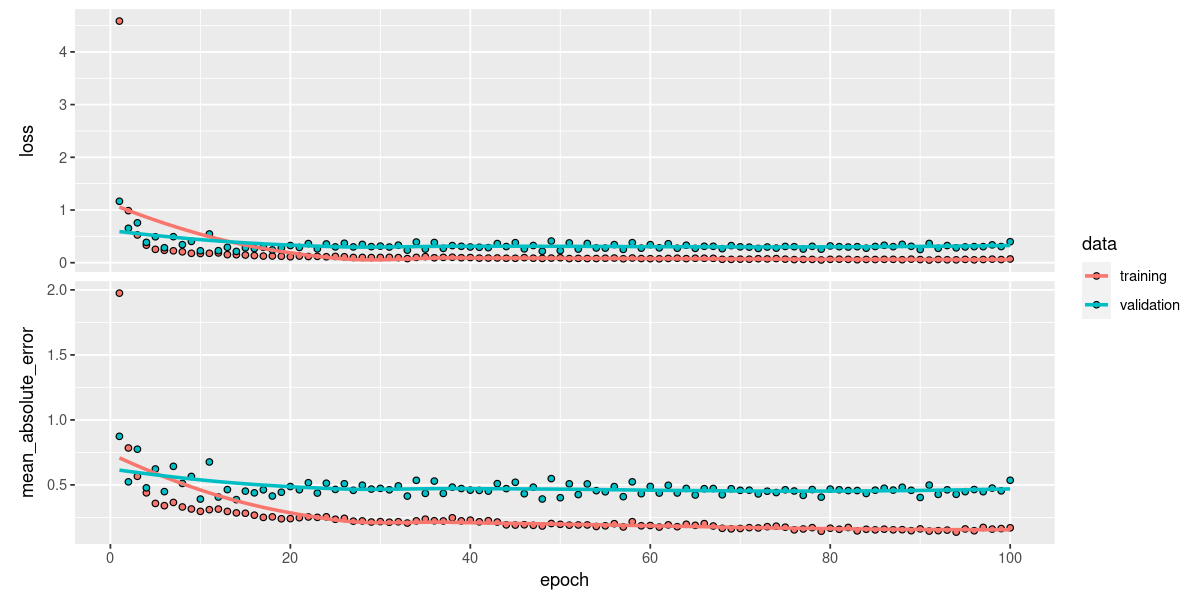

[1] 0.7142857

................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



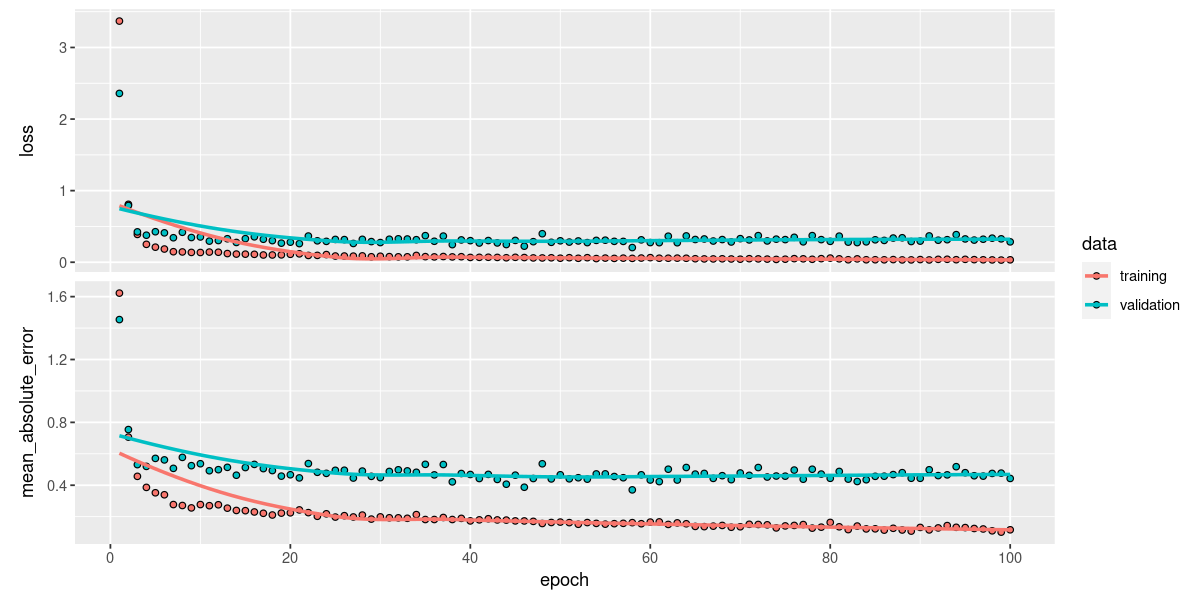

[1] 0.8214286

................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



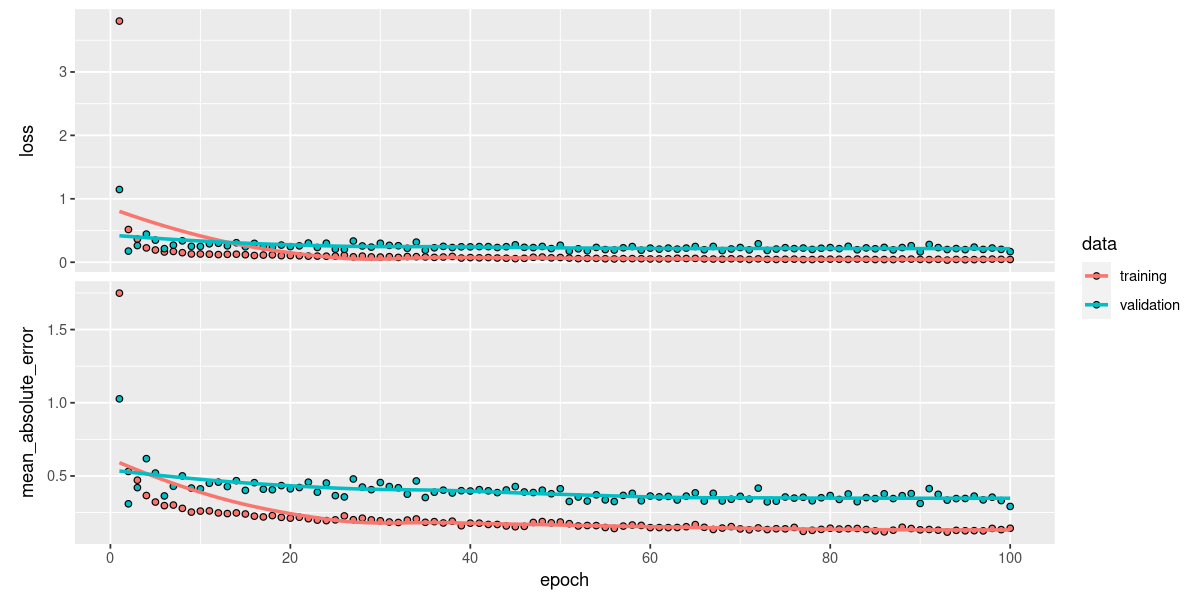

[1] 0.75

................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



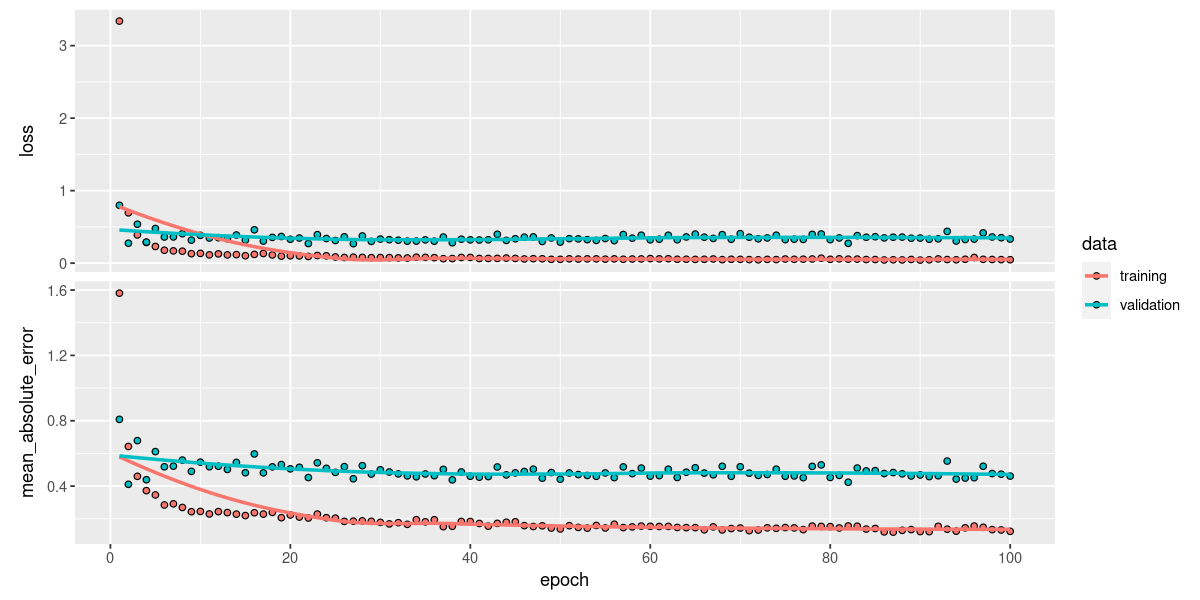

[1] 0.7142857

................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



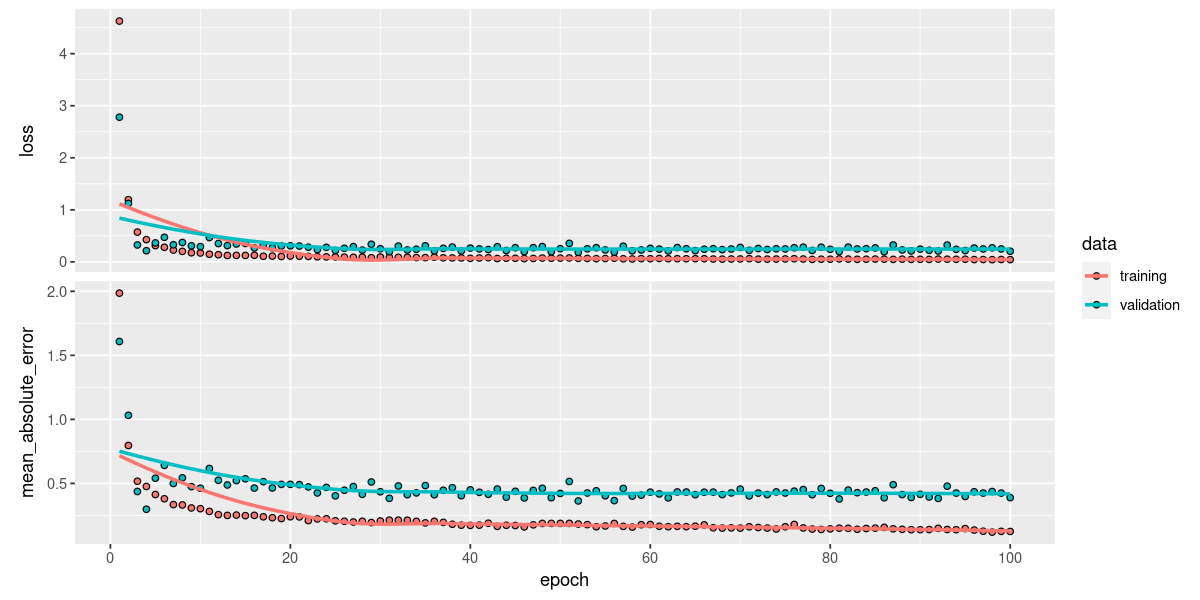

[1] 0.6428571

................................................................................
....................

`geom_smooth()` using formula 'y ~ x'



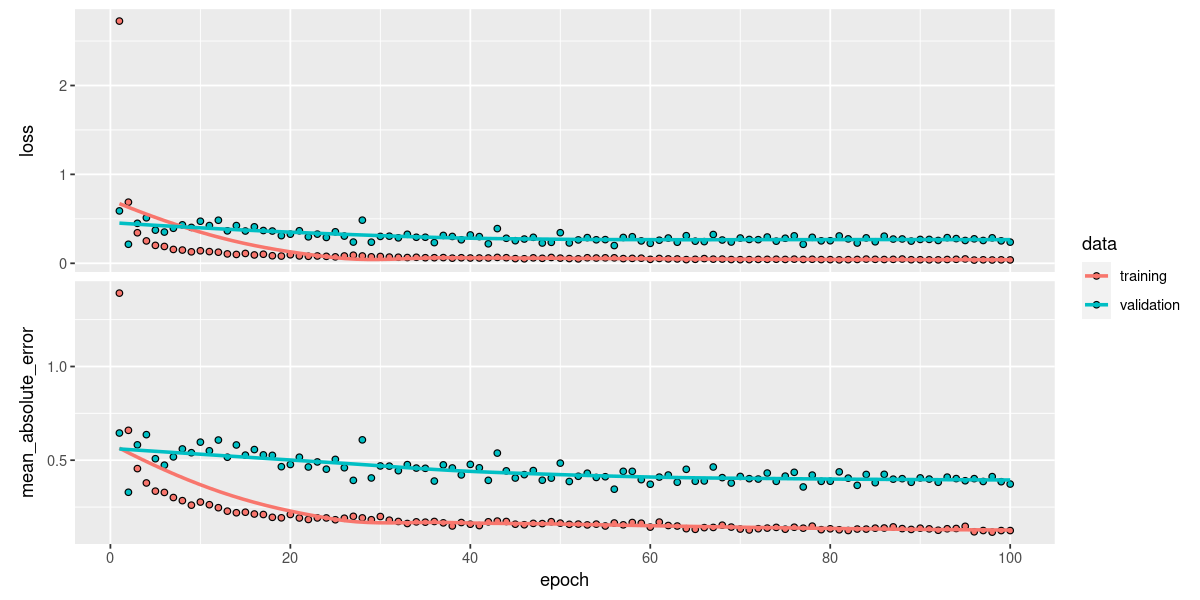

[1] 0.8571429


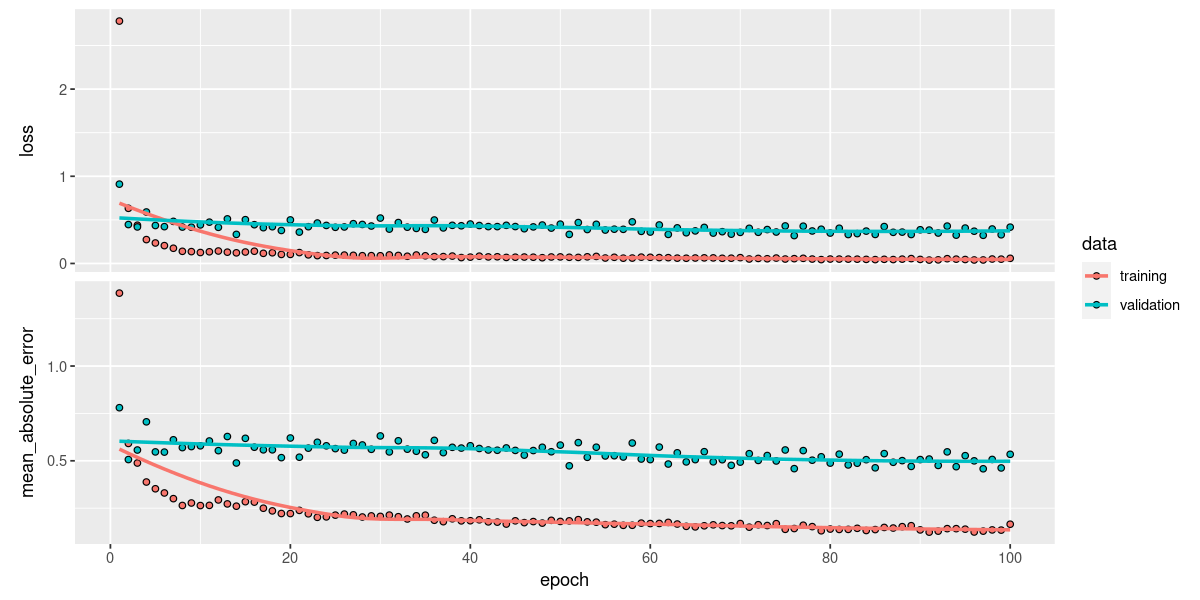

In [12]:
### Run the above model on 10 folds to check the average accuracy of the model
options(repr.plot.width=10, repr.plot.height=5)
folds <- cut(sample(nrow(data_new)),breaks=10,labels=FALSE)
p=NULL
for(i in 1:10){
    testIndexes <- which(folds==i,arr.ind=TRUE)
    test_data <- data_new[testIndexes, ]
    train_data <- data_new[-testIndexes, ]
    p=my_model(train_data,test_data)
    acc=c(acc,p)

}

In [13]:
avg.acc=sum(acc)/length(acc)
avg.acc

[1] 0.8035714

The above the model is giving average accuracy around 80% 